Medicine Classification


In [6]:
!git clone https://github.com/satwikug25/AML_Project.git

Cloning into 'AML_Project'...
remote: Enumerating objects: 5017, done.
remote: Total 5017 (delta 0), reused 0 (delta 0), pack-reused 5017 (from 2)
Receiving objects: 100% (5017/5017), 975.00 MiB | 14.68 MiB/s, done.
Resolving deltas: 100% (67/67), done.
Updating files: 100% (10388/10388), done.


In [15]:
!find AML_Project -type d -name train

AML_Project/medicine_boxes_split/train


In [7]:
import os
import json
from datetime import datetime
from typing import Tuple, Dict

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

import timm
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [8]:
def get_dataloaders(
    data_root: str,
    img_size: int = 224,
    batch_size: int = 32,
    num_workers: int = 4,
) -> Tuple[DataLoader, DataLoader, DataLoader, int, Dict[int, str]]:

    train_dir = os.path.join(data_root, "train")
    val_dir = os.path.join(data_root, "val")
    test_dir = os.path.join(data_root, "test")

    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    train_transform = transforms.Compose([
        transforms.Resize((img_size + 32, img_size + 32)),
        transforms.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])

    eval_transform = transforms.Compose([
        transforms.Resize((img_size + 32, img_size + 32)),
        transforms.CenterCrop(img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])

    train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
    val_dataset = datasets.ImageFolder(val_dir, transform=eval_transform)
    test_dataset = datasets.ImageFolder(test_dir, transform=eval_transform)

    num_classes = len(train_dataset.classes)
    idx_to_class = {i: c for i, c in enumerate(train_dataset.classes)}

    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True,
        num_workers=num_workers, pin_memory=True
    )
    val_loader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False,
        num_workers=num_workers, pin_memory=True
    )
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False,
        num_workers=num_workers, pin_memory=True
    )

    return train_loader, val_loader, test_loader, num_classes, idx_to_class

def build_resnet(num_classes: int, variant: str = "resnet18", pretrained: bool = True) -> nn.Module:
    if variant == "resnet18":
        model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1 if pretrained else None)
        in_features = model.fc.in_features
    elif variant == "resnet50":
        model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1 if pretrained else None)
        in_features = model.fc.in_features
    else:
        raise ValueError(f"Unsupported ResNet variant: {variant}")

    model.fc = nn.Linear(in_features, num_classes)
    return model

def build_vit(num_classes: int, variant: str = "vit_b16", pretrained: bool = True) -> nn.Module:
    if variant == "vit_b16":
        name = "vit_base_patch16_224"
    elif variant == "vit_s16":
        name = "vit_small_patch16_224"
    else:
        raise ValueError(f"Unsupported ViT variant: {variant}")

    model = timm.create_model(name, pretrained=pretrained, num_classes=num_classes)
    return model

def train_one_epoch(
    model: nn.Module,
    loader: DataLoader,
    optimizer: torch.optim.Optimizer,
    criterion: nn.Module,
    device: torch.device,
) -> Tuple[float, float]:
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

    avg_loss = running_loss / total
    acc = correct / total
    return avg_loss, acc

def eval_epoch(
    model: nn.Module,
    loader: DataLoader,
    criterion: nn.Module,
    device: torch.device,
) -> Tuple[float, float]:
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)

    avg_loss = running_loss / total
    acc = correct / total
    return avg_loss, acc

def test_model(
    model: nn.Module,
    loader: DataLoader,
    device: torch.device,
) -> Tuple[float, np.ndarray, np.ndarray]:
    model.eval()
    correct = 0
    total = 0
    all_true = []
    all_pred = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            outputs = model(images)
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)

            all_true.extend(labels.cpu().numpy())
            all_pred.extend(preds.cpu().numpy())

    acc = correct / total
    return acc, np.array(all_true), np.array(all_pred)


In [16]:
config = {
    "data_root": "AML_Project/medicine_boxes_split",
    "models": ["resnet18", "resnet50", "vit_b16", "vit_s16"],
    "epochs": 15,
    "batch_size": 32,
    "img_size": 224,
    "lr": 1e-4,
    "weight_decay": 1e-4,
    "num_workers": 4,
    "pretrained": True,
    "results_dir": "results",
}
os.makedirs(config["results_dir"], exist_ok=True)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
results_base = os.path.join(config["results_dir"], f"run_{timestamp}")
os.makedirs(results_base, exist_ok=True)

print("Configuration:")
for key, value in config.items():
    print(f"  {key}: {value}")
print(f"\nResults will be saved to: {results_base}")


Configuration:
  data_root: AML_Project/medicine_boxes_split
  models: ['resnet18', 'resnet50', 'vit_b16', 'vit_s16']
  epochs: 15
  batch_size: 32
  img_size: 224
  lr: 0.0001
  weight_decay: 0.0001
  num_workers: 4
  pretrained: True
  results_dir: results

Results will be saved to: results/run_20251214_210137


In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

train_loader, val_loader, test_loader, num_classes, idx_to_class = get_dataloaders(
    data_root=config["data_root"],
    img_size=config["img_size"],
    batch_size=config["batch_size"],
    num_workers=config["num_workers"],
)

print(f"\nFound {num_classes} classes:")
for idx, name in idx_to_class.items():
    print(f"  {idx}: {name}")
class_mapping_path = os.path.join(results_base, "class_mapping.json")
with open(class_mapping_path, "w") as f:
    json.dump({str(k): v for k, v in idx_to_class.items()}, f, indent=2)
print(f"\nClass mapping saved to: {class_mapping_path}")


Using device: cuda

Found 20 classes:
  0: acetaminophen
  1: albuterol
  2: amlodipine
  3: amoxicillin
  4: aspirin
  5: atorvastatin
  6: azithromycin
  7: cetirizine
  8: clopidogrel
  9: furosemide
  10: ibuprofen
  11: levothyroxine
  12: lisinopril
  13: loratadine
  14: losartan
  15: metformin
  16: naproxen
  17: omeprazole
  18: pantoprazole
  19: simvastatin

Class mapping saved to: results/run_20251214_210137/class_mapping.json


In [18]:
all_results = {}

for model_name in config["models"]:
    print("\n" + "="*80)
    print(f"Training Model: {model_name}")
    print("="*80)

    model_dir = os.path.join(results_base, model_name)
    os.makedirs(model_dir, exist_ok=True)

    if model_name.startswith("resnet"):
        model = build_resnet(num_classes, variant=model_name, pretrained=config["pretrained"])
    else:
        model = build_vit(num_classes, variant=model_name, pretrained=config["pretrained"])

    model = model.to(device)
    num_params = sum(p.numel() for p in model.parameters())
    print(f"Total parameters: {num_params:,}")

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=config["lr"], weight_decay=config["weight_decay"])
    try:
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode="max", factor=0.5, patience=3, verbose=False
        )
    except TypeError:
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode="max", factor=0.5, patience=3
        )

    best_val_acc = 0.0
    best_state = None
    train_history = {"loss": [], "acc": []}
    val_history = {"loss": [], "acc": []}

    print("\nStarting training...\n")

    for epoch in range(1, config["epochs"] + 1):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = eval_epoch(model, val_loader, criterion, device)

        scheduler.step(val_acc)

        train_history["loss"].append(train_loss)
        train_history["acc"].append(train_acc)
        val_history["loss"].append(val_loss)
        val_history["acc"].append(val_acc)

        print(
            f"Epoch {epoch:02d}/{config['epochs']:02d} | "
            f"Train loss: {train_loss:.4f}, acc: {train_acc:.4f} | "
            f"Val loss: {val_loss:.4f}, acc: {val_acc:.4f}"
        )

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = model.state_dict()

    print(f"\nBest val acc: {best_val_acc:.4f}")
    if best_state is not None:
        model.load_state_dict(best_state)

    checkpoint_path = os.path.join(model_dir, "best_model.pth")
    torch.save({
        "model_state_dict": model.state_dict(),
        "model_name": model_name,
        "num_classes": num_classes,
        "best_val_acc": best_val_acc,
        "config": config,
    }, checkpoint_path)
    print(f"Model saved to: {checkpoint_path}")

    test_acc, y_true, y_pred = test_model(model, test_loader, device)
    print(f"\nTest accuracy: {test_acc:.4f}")

    cm = confusion_matrix(y_true, y_pred)
    target_names = [idx_to_class[i] for i in sorted(idx_to_class.keys())]
    report = classification_report(y_true, y_pred, target_names=target_names, output_dict=True)

    print("\nConfusion Matrix (rows=true, cols=predicted):")
    print(cm)

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=target_names))
    metrics = {
        "model_name": model_name,
        "num_parameters": num_params,
        "best_val_acc": float(best_val_acc),
        "test_acc": float(test_acc),
        "train_history": {k: [float(x) for x in v] for k, v in train_history.items()},
        "val_history": {k: [float(x) for x in v] for k, v in val_history.items()},
        "classification_report": report,
    }

    metrics_path = os.path.join(model_dir, "metrics.json")
    with open(metrics_path, "w") as f:
        json.dump(metrics, f, indent=2)
    print(f"Metrics saved to: {metrics_path}")

    cm_path = os.path.join(model_dir, "confusion_matrix.npy")
    np.save(cm_path, cm)
    print(f"Confusion matrix saved to: {cm_path}")
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].plot(train_history["loss"], label="Train Loss", marker="o")
    axes[0].plot(val_history["loss"], label="Val Loss", marker="s")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].set_title(f"{model_name} - Training and Validation Loss")
    axes[0].legend()
    axes[0].grid(True)

    axes[1].plot(train_history["acc"], label="Train Acc", marker="o")
    axes[1].plot(val_history["acc"], label="Val Acc", marker="s")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Accuracy")
    axes[1].set_title(f"{model_name} - Training and Validation Accuracy")
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    history_plot_path = os.path.join(model_dir, "training_history.png")
    plt.savefig(history_plot_path, dpi=150, bbox_inches="tight")
    plt.close()
    print(f"Training history plot saved to: {history_plot_path}")

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=target_names, yticklabels=target_names,
                cbar_kws={"label": "Count"})
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    cm_plot_path = os.path.join(model_dir, "confusion_matrix.png")
    plt.savefig(cm_plot_path, dpi=150, bbox_inches="tight")
    plt.close()
    print(f"Confusion matrix plot saved to: {cm_plot_path}")

    class_names = [idx_to_class[i] for i in sorted(idx_to_class.keys())]
    precisions = [report[name]["precision"] for name in class_names]
    recalls = [report[name]["recall"] for name in class_names]
    f1_scores = [report[name]["f1-score"] for name in class_names]

    x = np.arange(len(class_names))
    width = 0.25

    fig, ax = plt.subplots(figsize=(14, 6))
    ax.bar(x - width, precisions, width, label="Precision", alpha=0.8)
    ax.bar(x, recalls, width, label="Recall", alpha=0.8)
    ax.bar(x + width, f1_scores, width, label="F1-Score", alpha=0.8)

    ax.set_xlabel("Class")
    ax.set_ylabel("Score")
    ax.set_title(f"{model_name} - Per-Class Metrics")
    ax.set_xticks(x)
    ax.set_xticklabels(class_names, rotation=45, ha="right")
    ax.legend()
    ax.grid(True, axis="y", alpha=0.3)
    plt.tight_layout()
    metrics_plot_path = os.path.join(model_dir, "per_class_metrics.png")
    plt.savefig(metrics_plot_path, dpi=150, bbox_inches="tight")
    plt.close()
    print(f"Per-class metrics plot saved to: {metrics_plot_path}")

    all_results[model_name] = {
        "test_acc": float(test_acc),
        "best_val_acc": float(best_val_acc),
        "num_parameters": num_params,
    }

    print(f"\nCompleted training for {model_name}")
    print(f"All outputs saved to: {model_dir}\n")



Training Model: resnet18
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 164MB/s]


Total parameters: 11,186,772

Starting training...

Epoch 01/15 | Train loss: 2.2367, acc: 0.3294 | Val loss: 1.8713, acc: 0.4440
Epoch 02/15 | Train loss: 1.5166, acc: 0.5653 | Val loss: 1.5213, acc: 0.5378
Epoch 03/15 | Train loss: 1.1414, acc: 0.6770 | Val loss: 1.3993, acc: 0.5938
Epoch 04/15 | Train loss: 0.8595, acc: 0.7563 | Val loss: 1.2162, acc: 0.6562
Epoch 05/15 | Train loss: 0.6621, acc: 0.8121 | Val loss: 1.0739, acc: 0.6888
Epoch 06/15 | Train loss: 0.5144, acc: 0.8621 | Val loss: 0.9794, acc: 0.7292
Epoch 07/15 | Train loss: 0.4068, acc: 0.8953 | Val loss: 0.9397, acc: 0.7240
Epoch 08/15 | Train loss: 0.3377, acc: 0.9121 | Val loss: 0.9344, acc: 0.7448
Epoch 09/15 | Train loss: 0.3090, acc: 0.9102 | Val loss: 0.8975, acc: 0.7474
Epoch 10/15 | Train loss: 0.2728, acc: 0.9265 | Val loss: 0.8654, acc: 0.7656
Epoch 11/15 | Train loss: 0.2412, acc: 0.9323 | Val loss: 0.8746, acc: 0.7826
Epoch 12/15 | Train loss: 0.1977, acc: 0.9450 | Val loss: 0.8416, acc: 0.7747
Epoch 13/15 

100%|██████████| 97.8M/97.8M [00:00<00:00, 236MB/s]


Total parameters: 23,549,012

Starting training...

Epoch 01/15 | Train loss: 2.2057, acc: 0.3357 | Val loss: 1.8212, acc: 0.4297
Epoch 02/15 | Train loss: 1.4743, acc: 0.5659 | Val loss: 1.4889, acc: 0.5299
Epoch 03/15 | Train loss: 1.0397, acc: 0.6985 | Val loss: 1.2159, acc: 0.6458
Epoch 04/15 | Train loss: 0.7850, acc: 0.7720 | Val loss: 1.0652, acc: 0.6797
Epoch 05/15 | Train loss: 0.5752, acc: 0.8334 | Val loss: 1.0538, acc: 0.6992
Epoch 06/15 | Train loss: 0.4720, acc: 0.8605 | Val loss: 0.8433, acc: 0.7578
Epoch 07/15 | Train loss: 0.3834, acc: 0.8922 | Val loss: 0.9089, acc: 0.7513
Epoch 08/15 | Train loss: 0.3637, acc: 0.8925 | Val loss: 0.8099, acc: 0.7773
Epoch 09/15 | Train loss: 0.2899, acc: 0.9088 | Val loss: 0.8403, acc: 0.7721
Epoch 10/15 | Train loss: 0.2590, acc: 0.9229 | Val loss: 0.7649, acc: 0.7969
Epoch 11/15 | Train loss: 0.2670, acc: 0.9171 | Val loss: 0.8586, acc: 0.7708
Epoch 12/15 | Train loss: 0.2432, acc: 0.9251 | Val loss: 0.8298, acc: 0.7760
Epoch 13/15 

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Total parameters: 85,814,036

Starting training...

Epoch 01/15 | Train loss: 2.5370, acc: 0.2277 | Val loss: 2.4316, acc: 0.2539
Epoch 02/15 | Train loss: 2.0134, acc: 0.3777 | Val loss: 2.0042, acc: 0.3984
Epoch 03/15 | Train loss: 1.6729, acc: 0.4772 | Val loss: 1.7994, acc: 0.4453
Epoch 04/15 | Train loss: 1.3635, acc: 0.5808 | Val loss: 1.5944, acc: 0.5078
Epoch 05/15 | Train loss: 1.1450, acc: 0.6416 | Val loss: 1.5312, acc: 0.5247
Epoch 06/15 | Train loss: 1.0094, acc: 0.6836 | Val loss: 1.4633, acc: 0.5794
Epoch 07/15 | Train loss: 0.8503, acc: 0.7356 | Val loss: 1.4981, acc: 0.5885
Epoch 08/15 | Train loss: 0.7613, acc: 0.7599 | Val loss: 1.4665, acc: 0.5807
Epoch 09/15 | Train loss: 0.6592, acc: 0.7762 | Val loss: 1.4497, acc: 0.6107
Epoch 10/15 | Train loss: 0.6238, acc: 0.7955 | Val loss: 1.3942, acc: 0.6146
Epoch 11/15 | Train loss: 0.5335, acc: 0.8226 | Val loss: 1.4154, acc: 0.6276
Epoch 12/15 | Train loss: 0.5024, acc: 0.8326 | Val loss: 1.3297, acc: 0.6393
Epoch 13/15 

model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

Total parameters: 21,673,364

Starting training...

Epoch 01/15 | Train loss: 2.4097, acc: 0.2553 | Val loss: 1.9800, acc: 0.3893
Epoch 02/15 | Train loss: 1.7786, acc: 0.4512 | Val loss: 1.7566, acc: 0.4622
Epoch 03/15 | Train loss: 1.4544, acc: 0.5565 | Val loss: 1.6938, acc: 0.5052
Epoch 04/15 | Train loss: 1.1634, acc: 0.6413 | Val loss: 1.4349, acc: 0.5742
Epoch 05/15 | Train loss: 0.9436, acc: 0.7148 | Val loss: 1.3383, acc: 0.6003
Epoch 06/15 | Train loss: 0.7866, acc: 0.7571 | Val loss: 1.3813, acc: 0.6133
Epoch 07/15 | Train loss: 0.7539, acc: 0.7621 | Val loss: 1.2682, acc: 0.6172
Epoch 08/15 | Train loss: 0.6387, acc: 0.7969 | Val loss: 1.2138, acc: 0.6510
Epoch 09/15 | Train loss: 0.5384, acc: 0.8326 | Val loss: 1.1901, acc: 0.6589
Epoch 10/15 | Train loss: 0.5150, acc: 0.8367 | Val loss: 1.1314, acc: 0.6654
Epoch 11/15 | Train loss: 0.4702, acc: 0.8489 | Val loss: 1.2001, acc: 0.6719
Epoch 12/15 | Train loss: 0.4344, acc: 0.8599 | Val loss: 1.1134, acc: 0.6810
Epoch 13/15 

In [19]:
print("\n" + "="*80)
print("SUMMARY OF ALL MODELS")
print("="*80)
print(f"{'Model':<15} {'Test Acc':<12} {'Val Acc':<12} {'Parameters':<15}")
print("-"*80)

for model_name, results in all_results.items():
    print(f"{model_name:<15} {results['test_acc']:<12.4f} {results['best_val_acc']:<12.4f} {results['num_parameters']:<15,}")

summary_path = os.path.join(results_base, "summary.json")
with open(summary_path, "w") as f:
    json.dump(all_results, f, indent=2)
print(f"\nSummary saved to: {summary_path}")

best_model = max(all_results.items(), key=lambda x: x[1]["test_acc"])
print(f"\nBest Model: {best_model[0]} (Test Acc: {best_model[1]['test_acc']:.4f})")
print(f"\nAll results saved to: {results_base}")



SUMMARY OF ALL MODELS
Model           Test Acc     Val Acc      Parameters     
--------------------------------------------------------------------------------
resnet18        0.7597       0.7826       11,186,772     
resnet50        0.7922       0.8060       23,549,012     
vit_b16         0.6320       0.6393       85,814,036     
vit_s16         0.6671       0.7005       21,673,364     

Summary saved to: results/run_20251214_210137/summary.json

Best Model: resnet50 (Test Acc: 0.7922)

All results saved to: results/run_20251214_210137


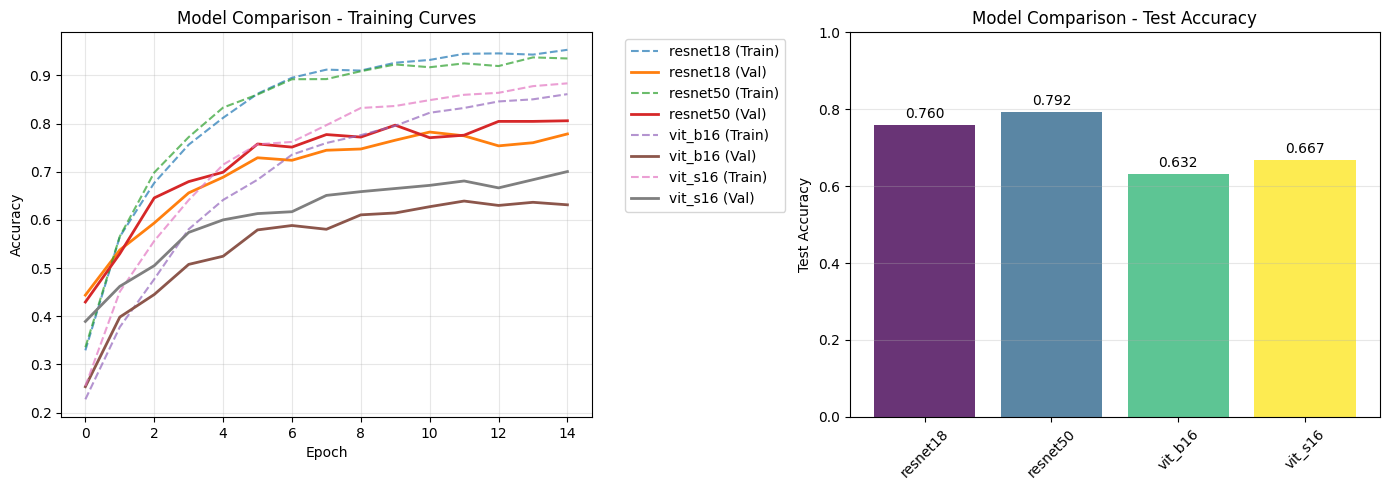

Comparison plot saved to: results/run_20251214_210137/comparison/model_comparison.png


In [20]:
comparison_dir = os.path.join(results_base, "comparison")
os.makedirs(comparison_dir, exist_ok=True)

all_train_histories = {}
all_val_histories = {}
all_test_accs = {}

for model_name in config["models"]:
    metrics_path = os.path.join(results_base, model_name, "metrics.json")
    if os.path.exists(metrics_path):
        with open(metrics_path, "r") as f:
            metrics = json.load(f)
            all_train_histories[model_name] = metrics["train_history"]["acc"]
            all_val_histories[model_name] = metrics["val_history"]["acc"]
            all_test_accs[model_name] = metrics["test_acc"]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for model_name in all_train_histories.keys():
    axes[0].plot(all_train_histories[model_name], label=f"{model_name} (Train)", linestyle="--", alpha=0.7)
    axes[0].plot(all_val_histories[model_name], label=f"{model_name} (Val)", linewidth=2)

axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy")
axes[0].set_title("Model Comparison - Training Curves")
axes[0].legend(bbox_to_anchor=(1.05, 1), loc="upper left")
axes[0].grid(True, alpha=0.3)

models = list(all_test_accs.keys())
accs = list(all_test_accs.values())
colors = plt.cm.viridis(np.linspace(0, 1, len(models)))

axes[1].bar(models, accs, color=colors, alpha=0.8)
axes[1].set_ylabel("Test Accuracy")
axes[1].set_title("Model Comparison - Test Accuracy")
axes[1].set_ylim([0, 1])
axes[1].grid(True, axis="y", alpha=0.3)
axes[1].tick_params(axis="x", rotation=45)

for i, (model, acc) in enumerate(zip(models, accs)):
    axes[1].text(i, acc + 0.01, f"{acc:.3f}", ha="center", va="bottom")

plt.tight_layout()
comparison_plot_path = os.path.join(comparison_dir, "model_comparison.png")
plt.savefig(comparison_plot_path, dpi=150, bbox_inches="tight")
plt.show()
print(f"Comparison plot saved to: {comparison_plot_path}")


In [21]:
print(f"Results directory: {results_base}")
print("\nDirectory structure:")
for root, dirs, files in os.walk(results_base):
    level = root.replace(results_base, "").count(os.sep)
    indent = " " * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = " " * 2 * (level + 1)
    for file in files[:10]:
        print(f"{subindent}{file}")
    if len(files) > 10:
        print(f"{subindent}... and {len(files) - 10} more files")


Results directory: results/run_20251214_210137

Directory structure:
run_20251214_210137/
  summary.json
  class_mapping.json
  resnet50/
    per_class_metrics.png
    confusion_matrix.png
    confusion_matrix.npy
    training_history.png
    best_model.pth
    metrics.json
  resnet18/
    per_class_metrics.png
    confusion_matrix.png
    confusion_matrix.npy
    training_history.png
    best_model.pth
    metrics.json
  vit_b16/
    per_class_metrics.png
    confusion_matrix.png
    confusion_matrix.npy
    training_history.png
    best_model.pth
    metrics.json
  comparison/
    model_comparison.png
  vit_s16/
    per_class_metrics.png
    confusion_matrix.png
    confusion_matrix.npy
    training_history.png
    best_model.pth
    metrics.json


In [22]:
if os.path.exists(summary_path):
    with open(summary_path, "r") as f:
        summary = json.load(f)

    print("\nSummary of Results:")
    print(json.dumps(summary, indent=2))



Summary of Results:
{
  "resnet18": {
    "test_acc": 0.7596996245306633,
    "best_val_acc": 0.7825520833333334,
    "num_parameters": 11186772
  },
  "resnet50": {
    "test_acc": 0.7922403003754693,
    "best_val_acc": 0.8059895833333334,
    "num_parameters": 23549012
  },
  "vit_b16": {
    "test_acc": 0.6320400500625782,
    "best_val_acc": 0.6393229166666666,
    "num_parameters": 85814036
  },
  "vit_s16": {
    "test_acc": 0.6670838548185232,
    "best_val_acc": 0.7005208333333334,
    "num_parameters": 21673364
  }
}



Images for RESNET18

confusion_matrix.png:


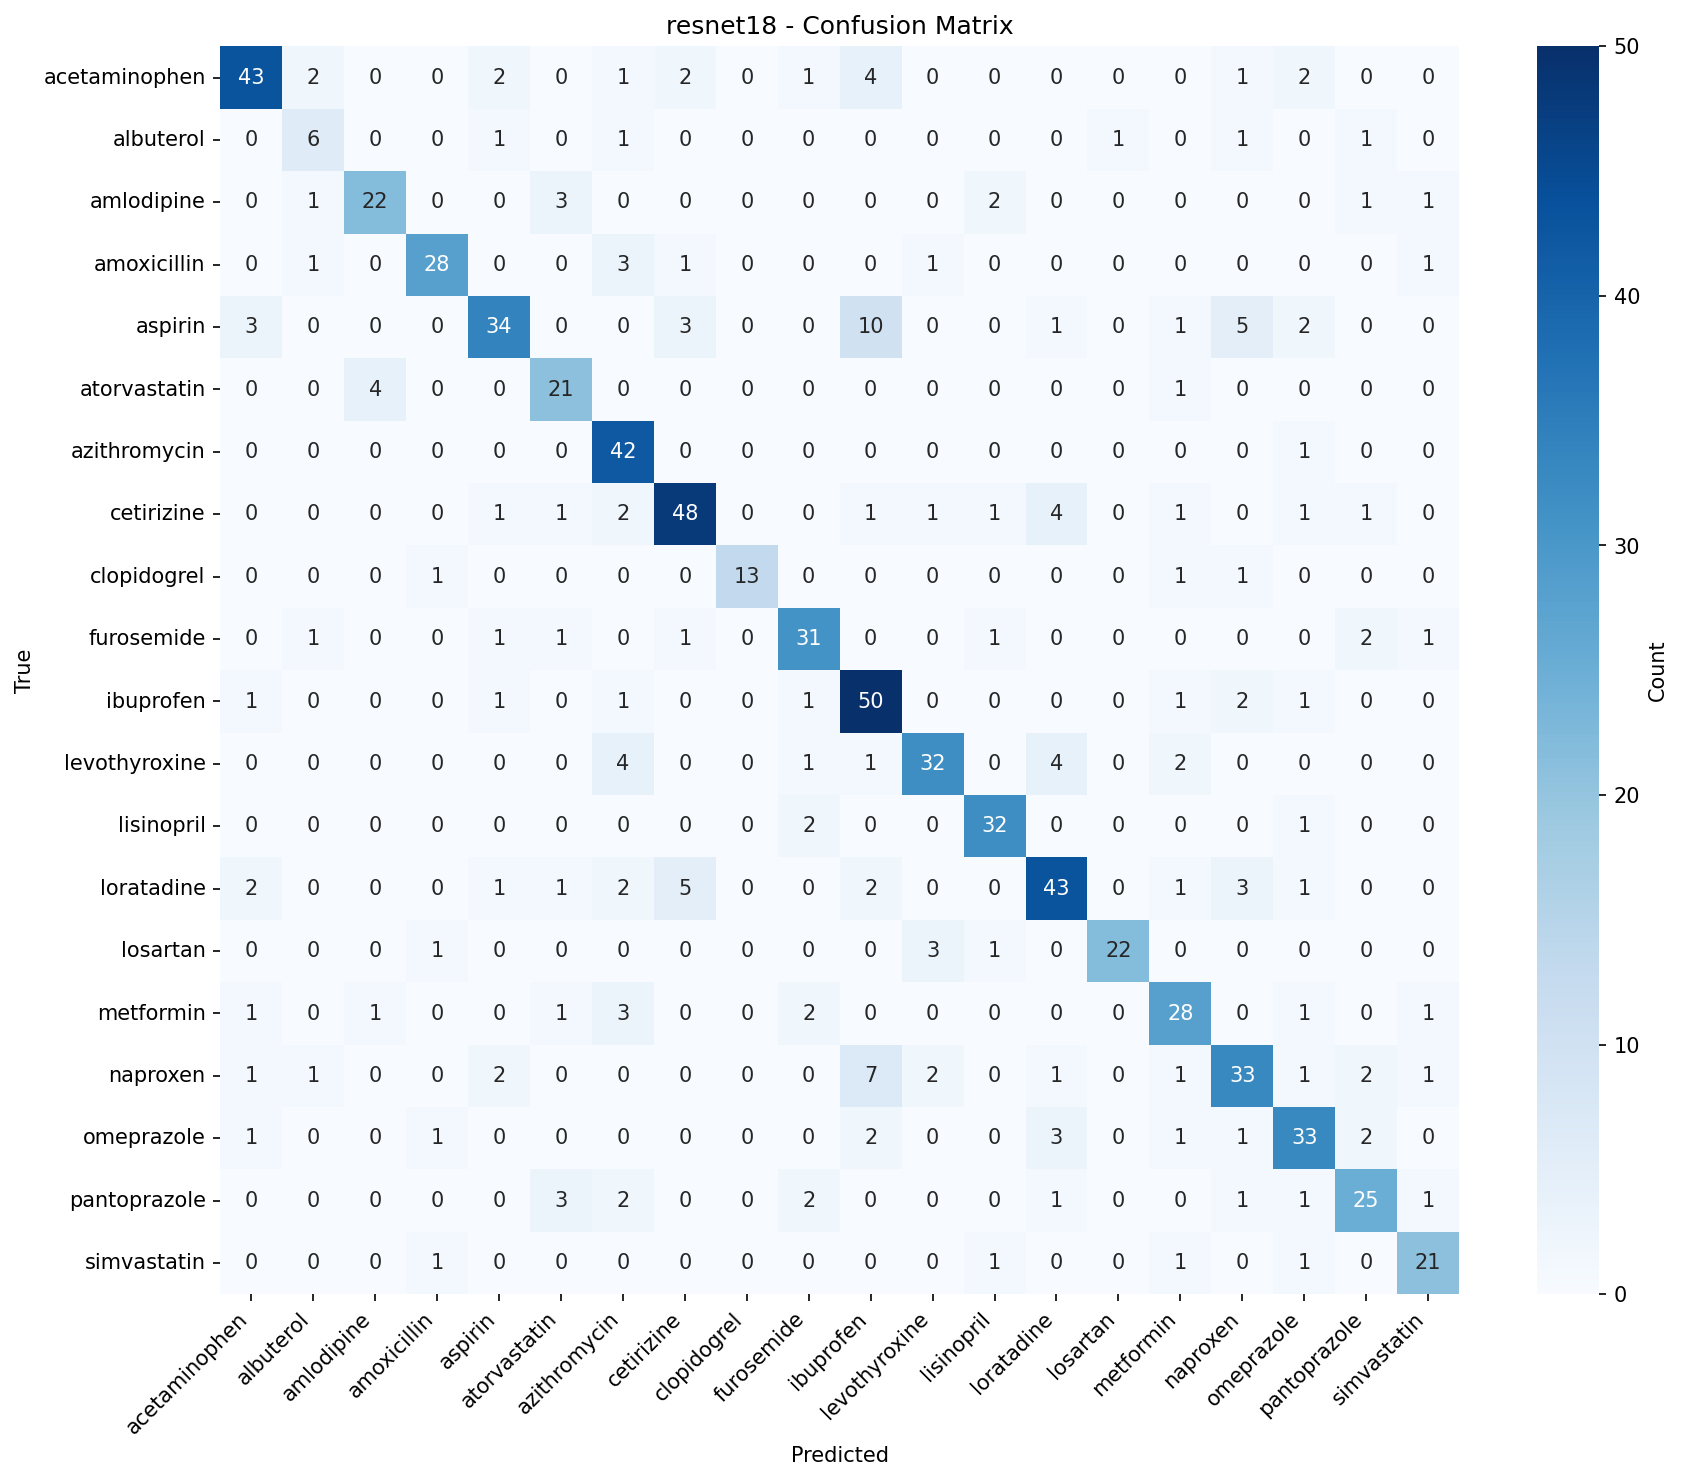


per_class_metrics.png:


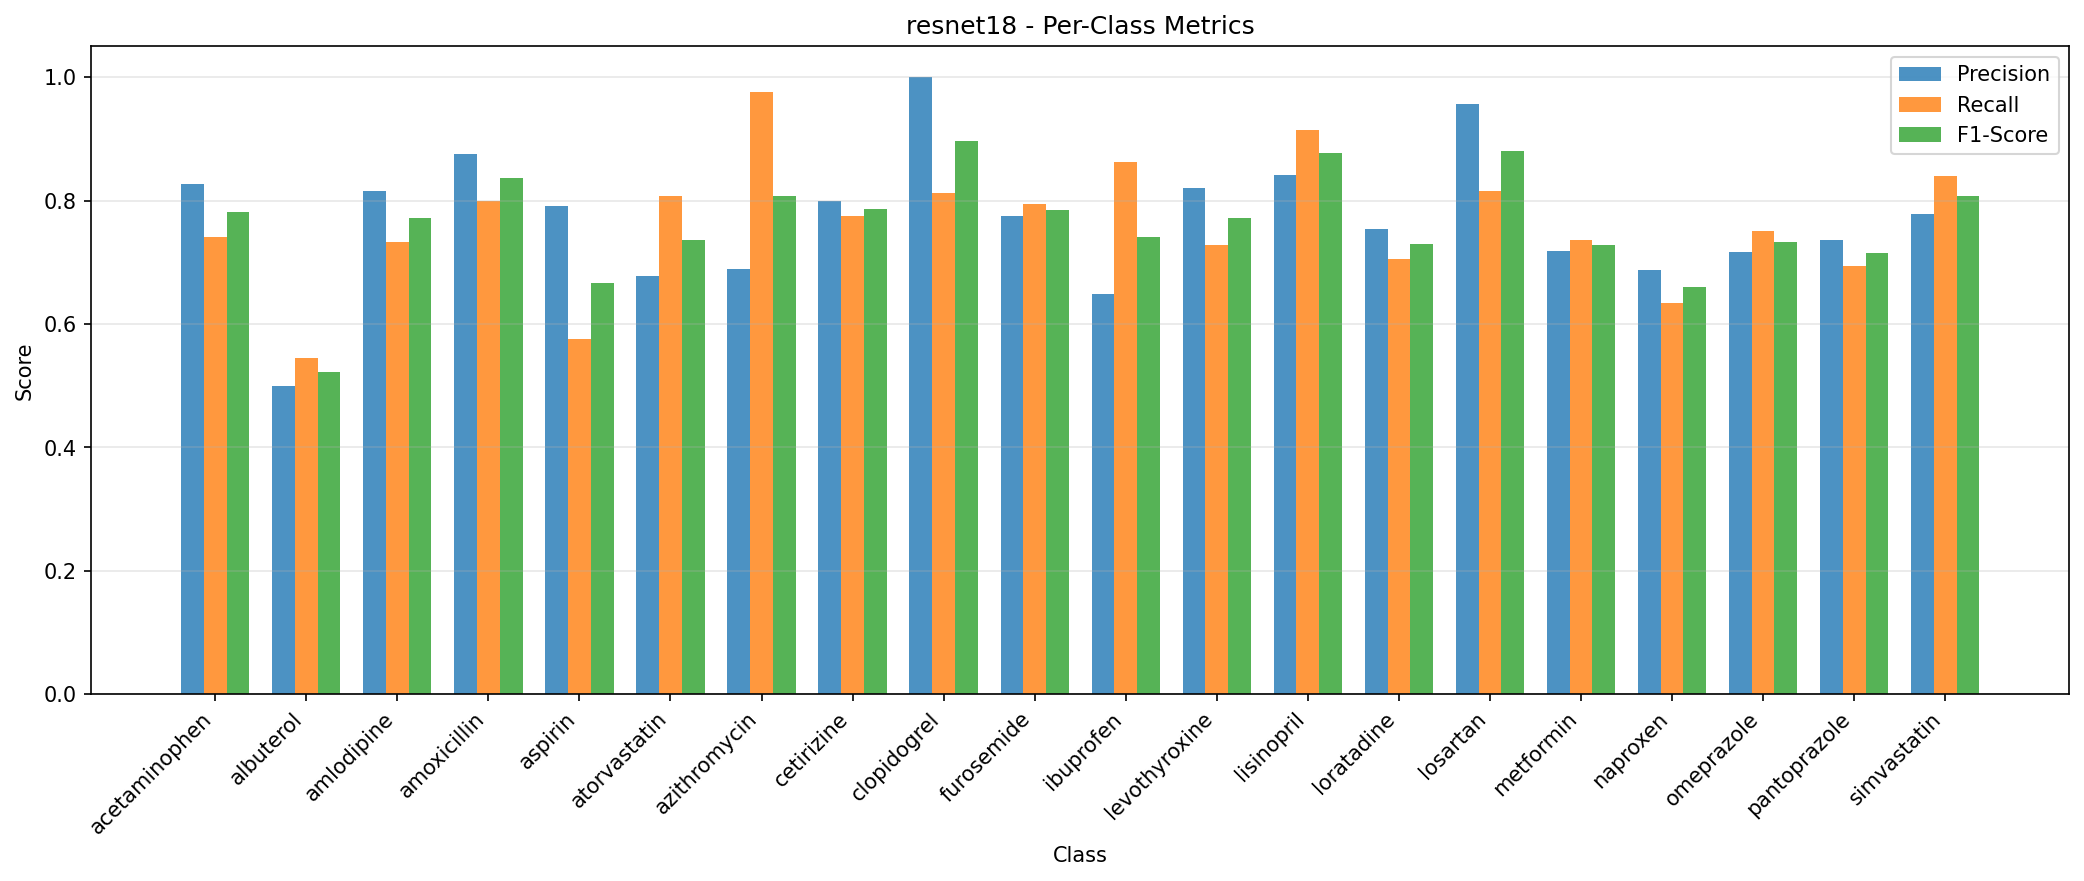


training_history.png:


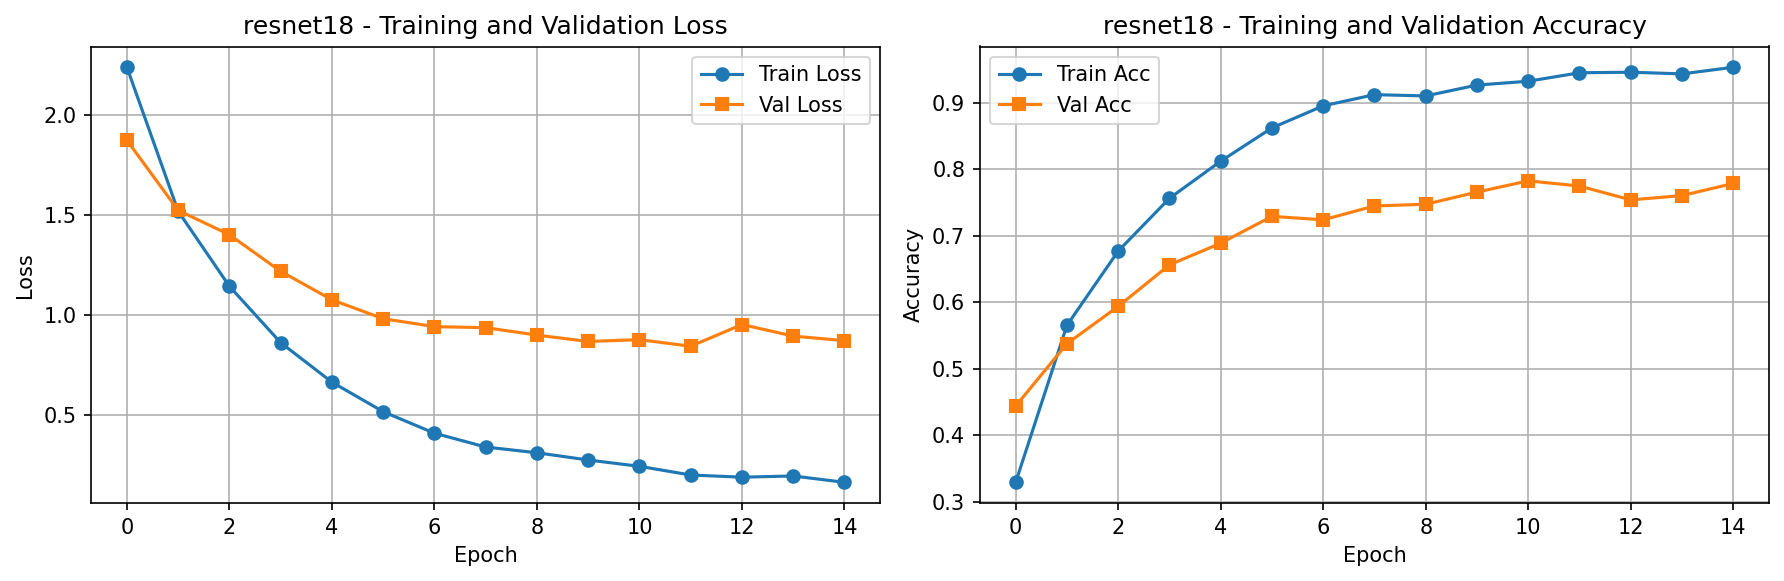



Images for RESNET50

confusion_matrix.png:


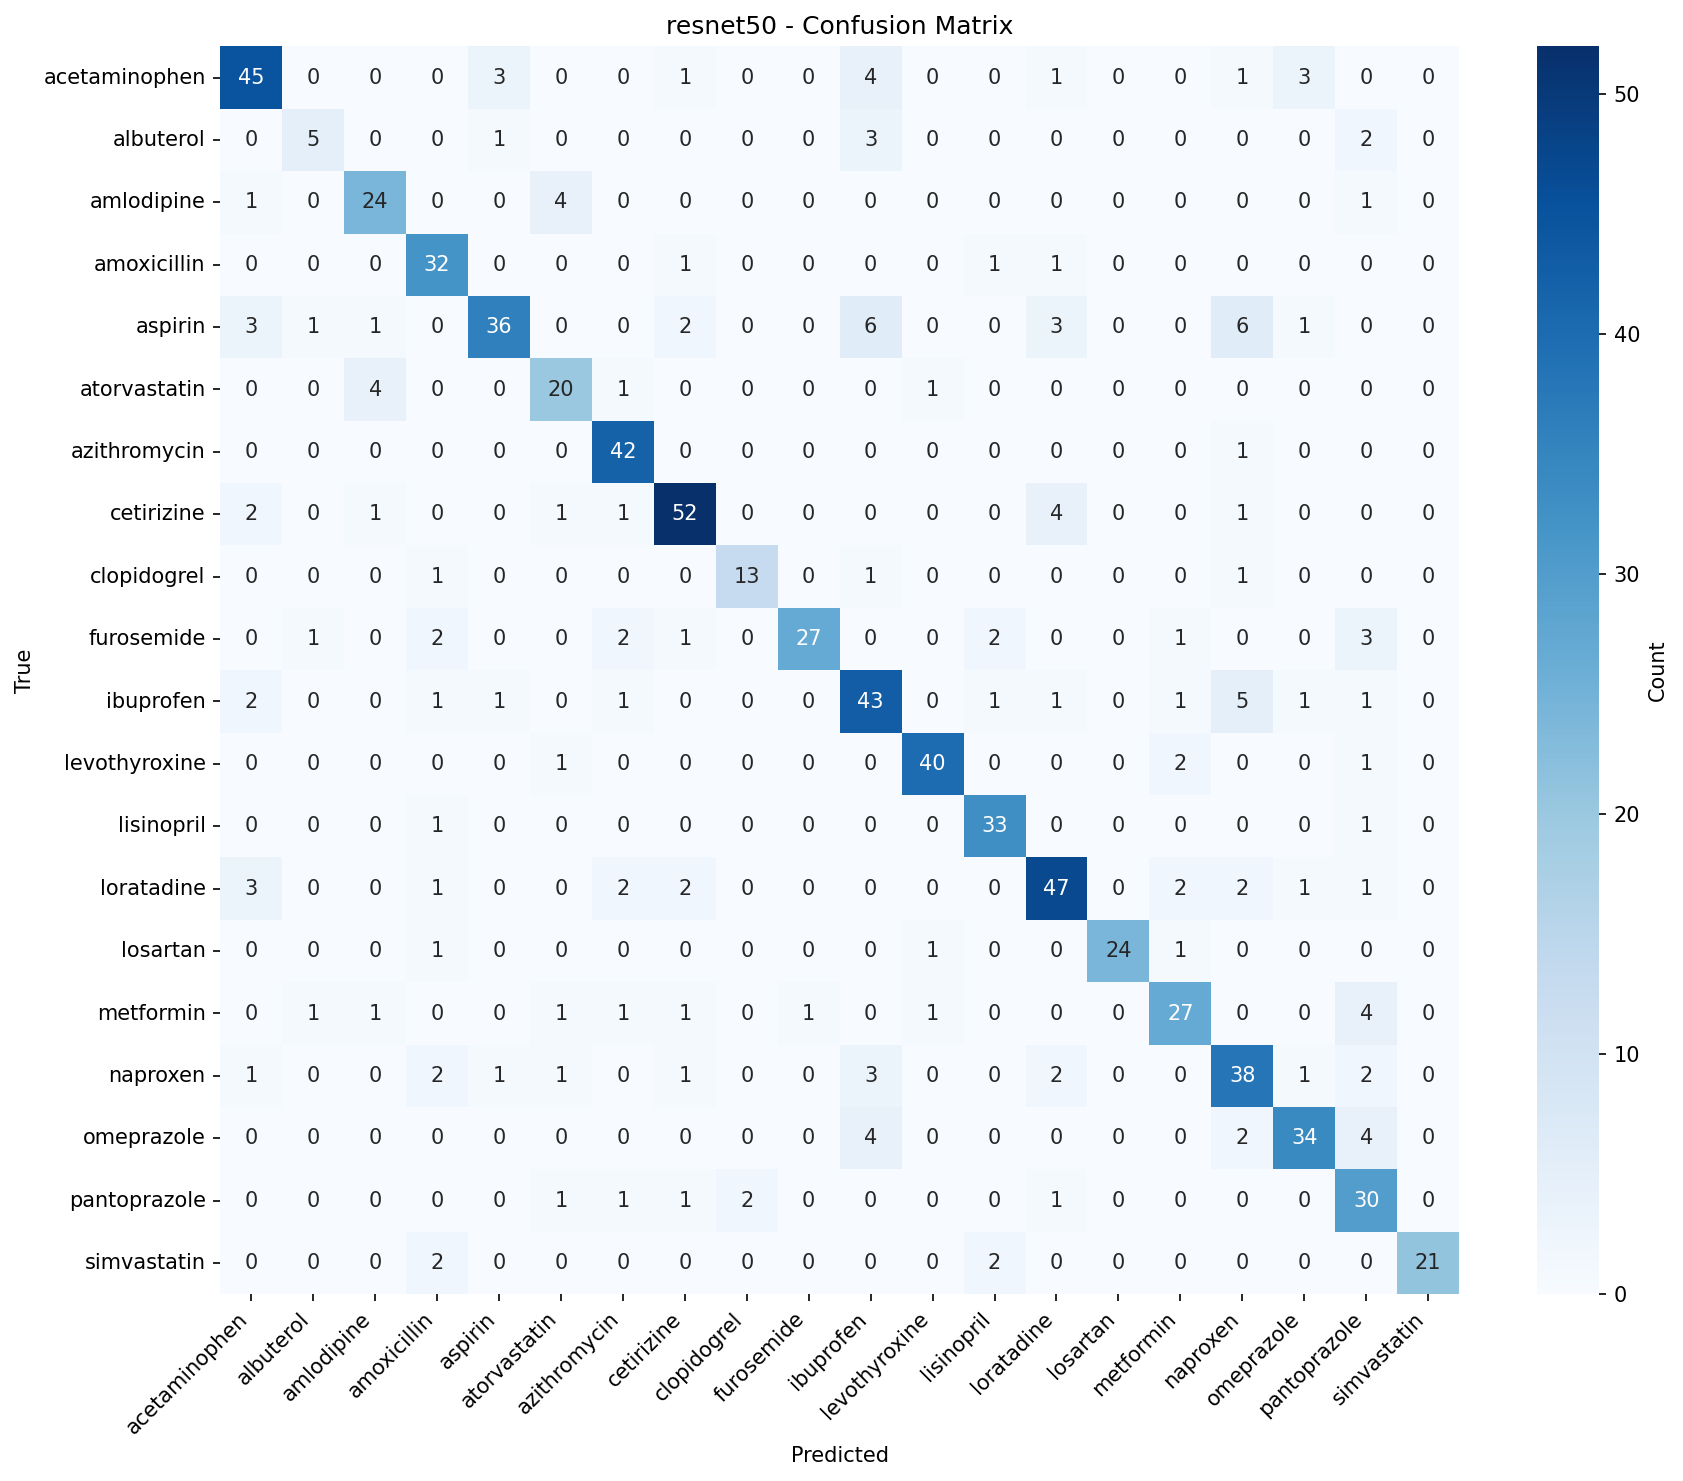


per_class_metrics.png:


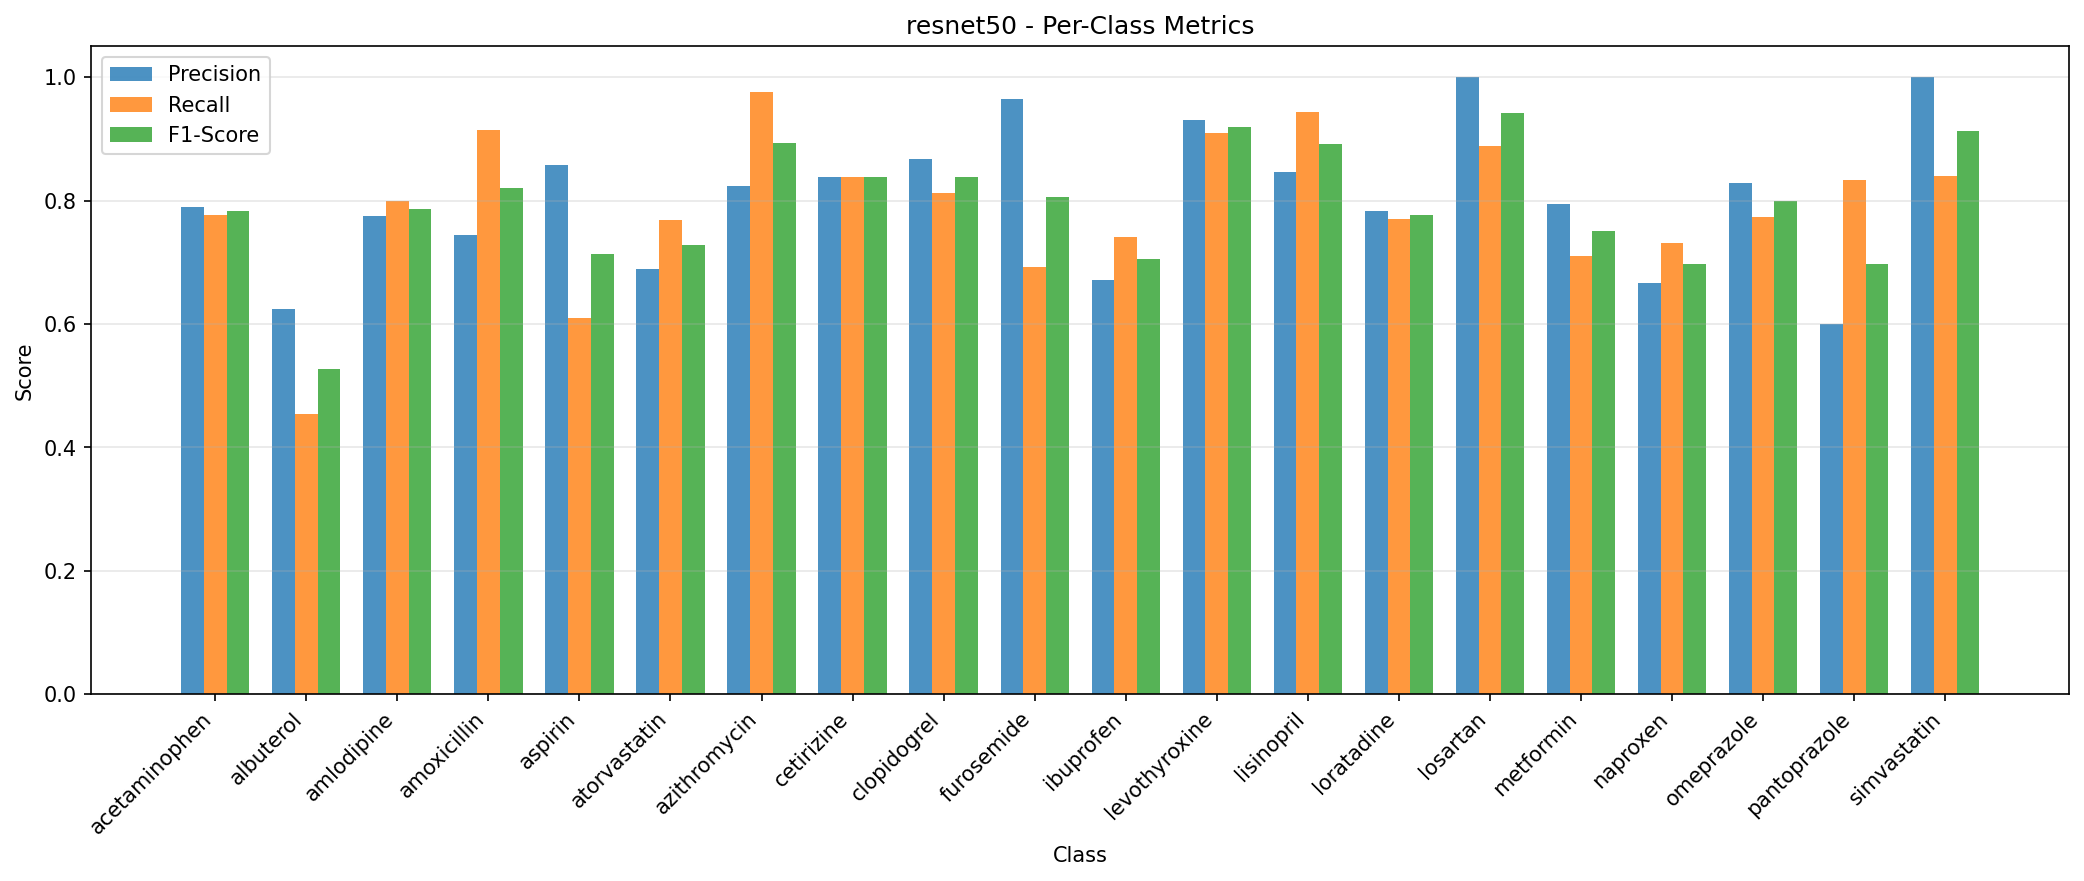


training_history.png:


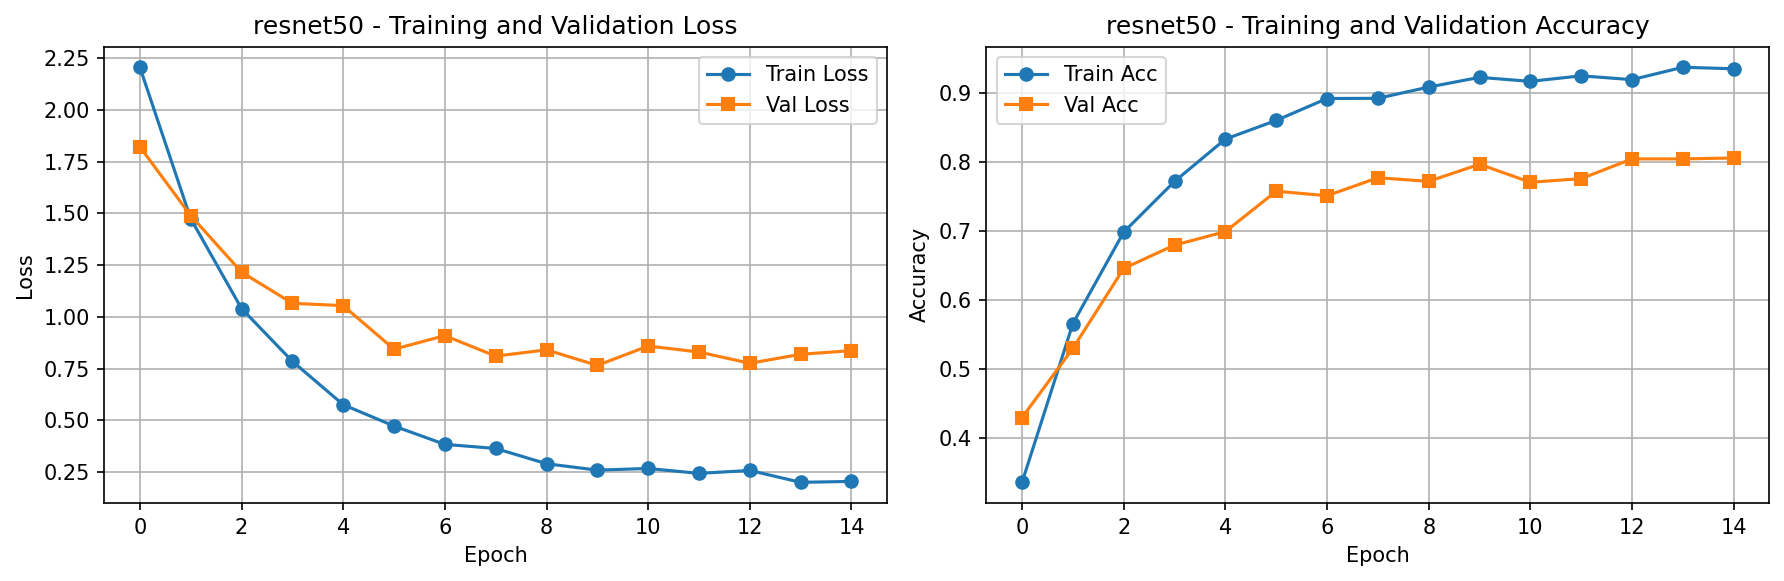



Images for VIT_B16

confusion_matrix.png:


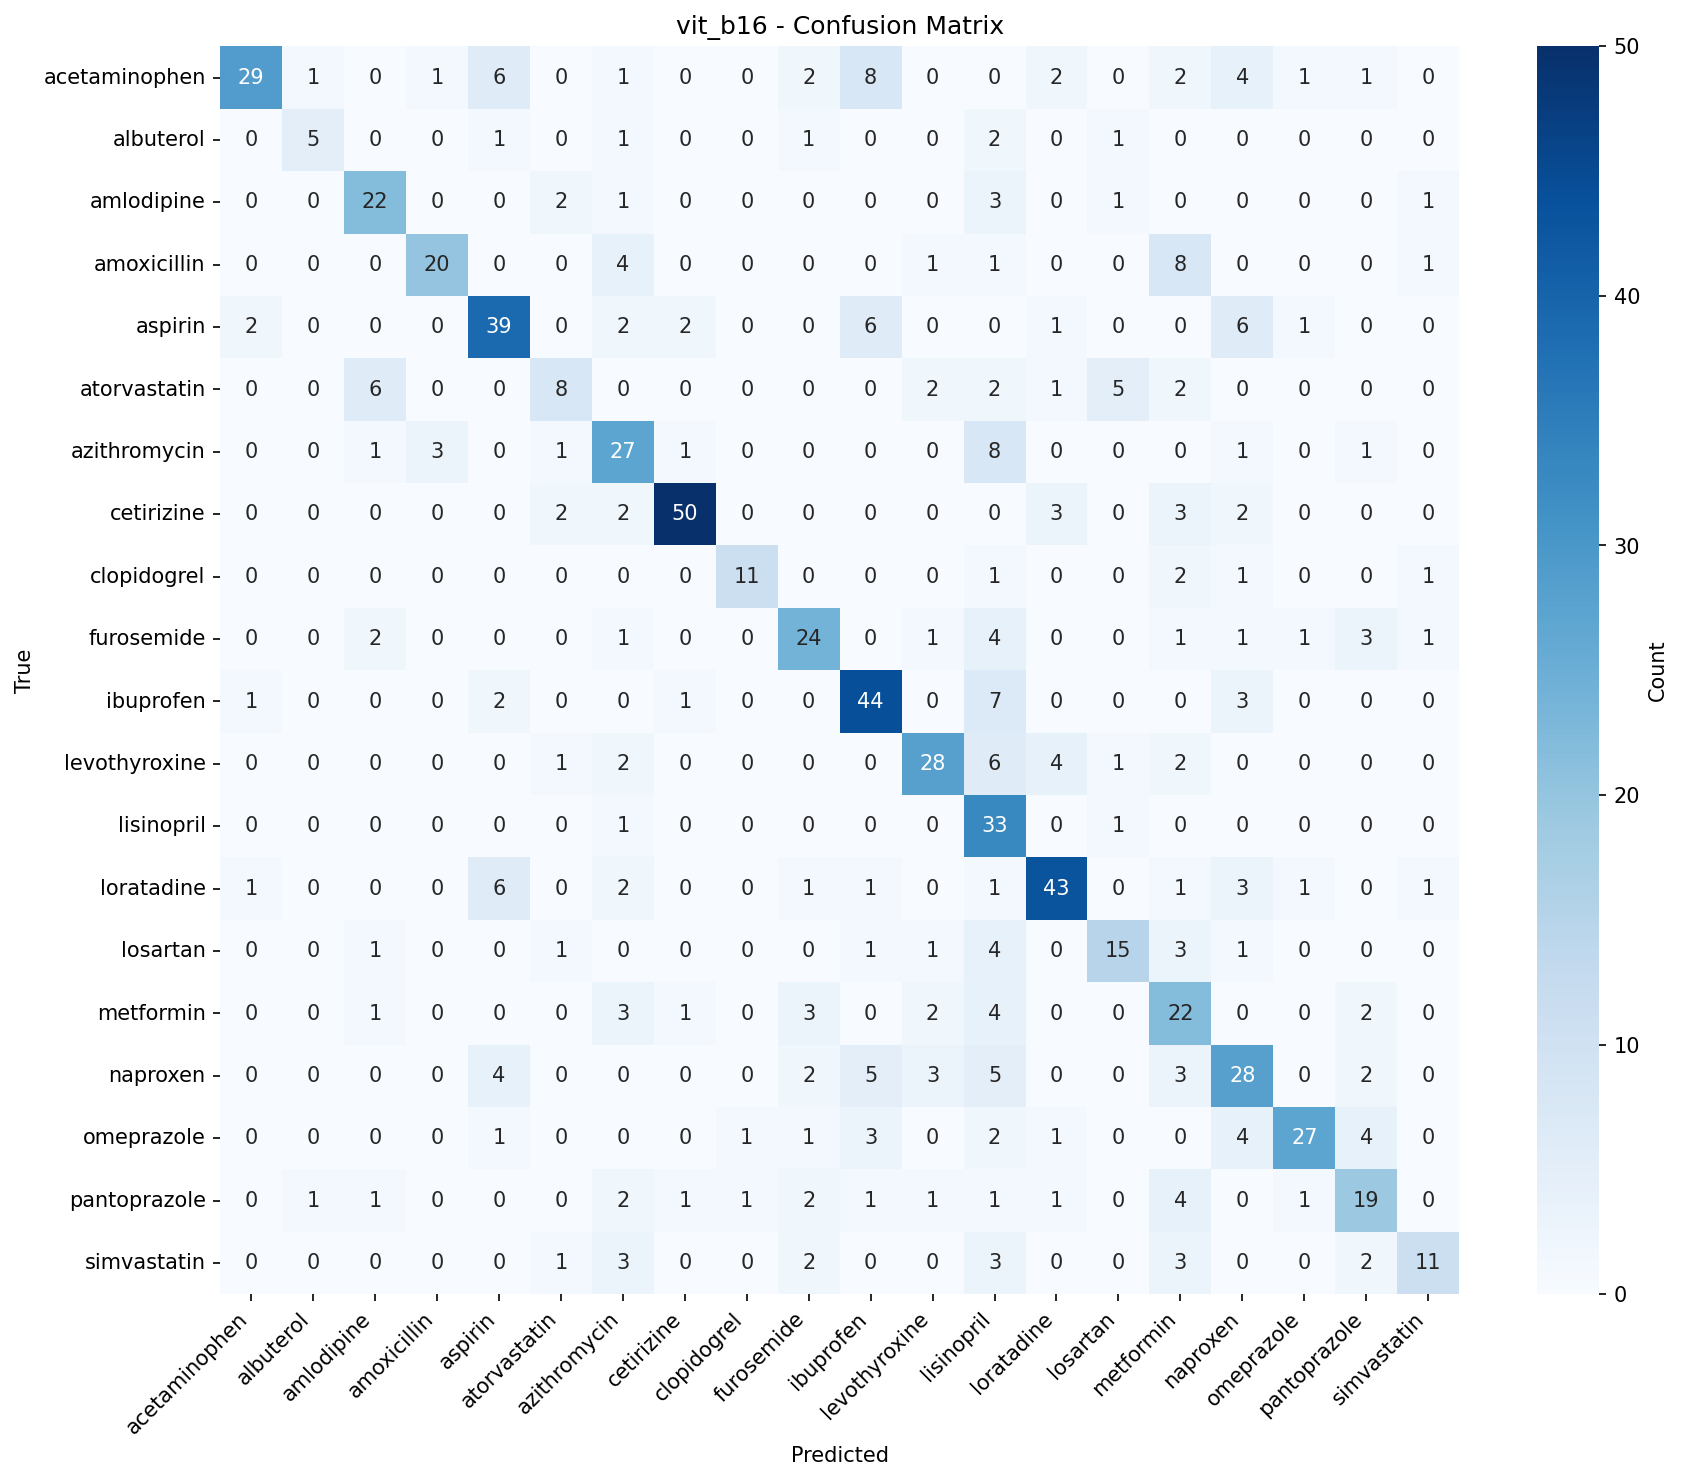


per_class_metrics.png:


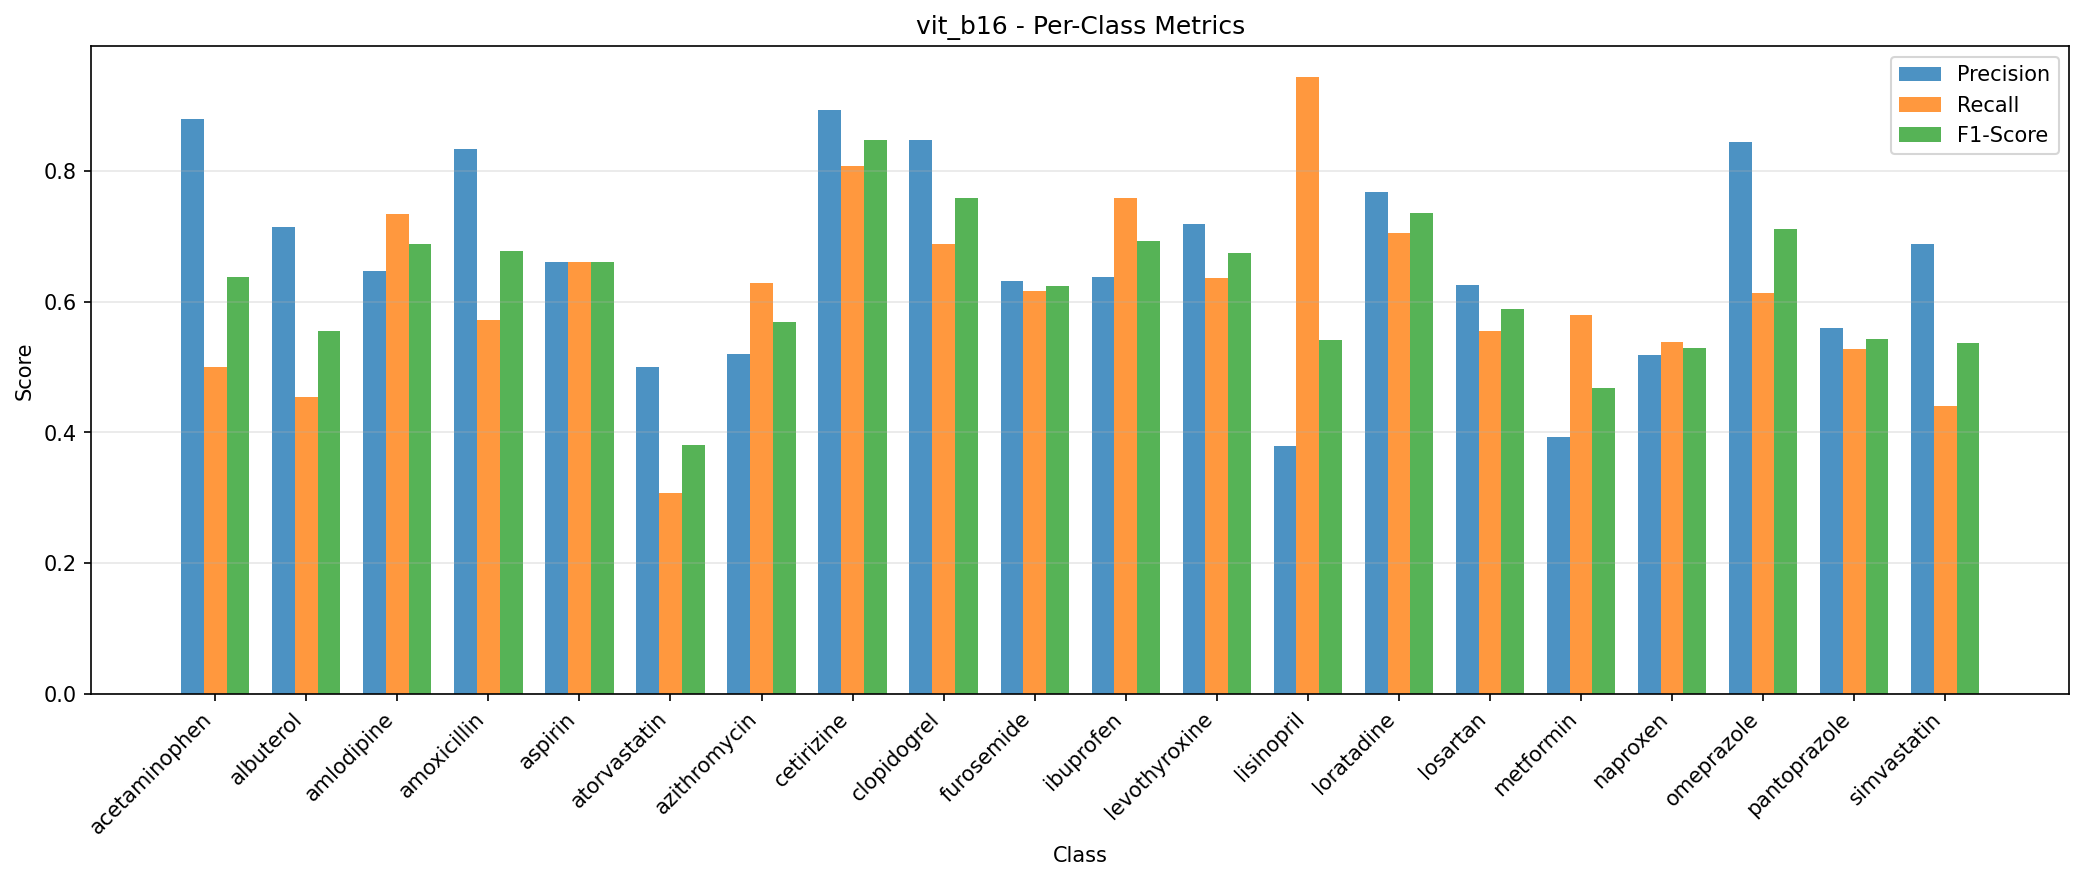


training_history.png:


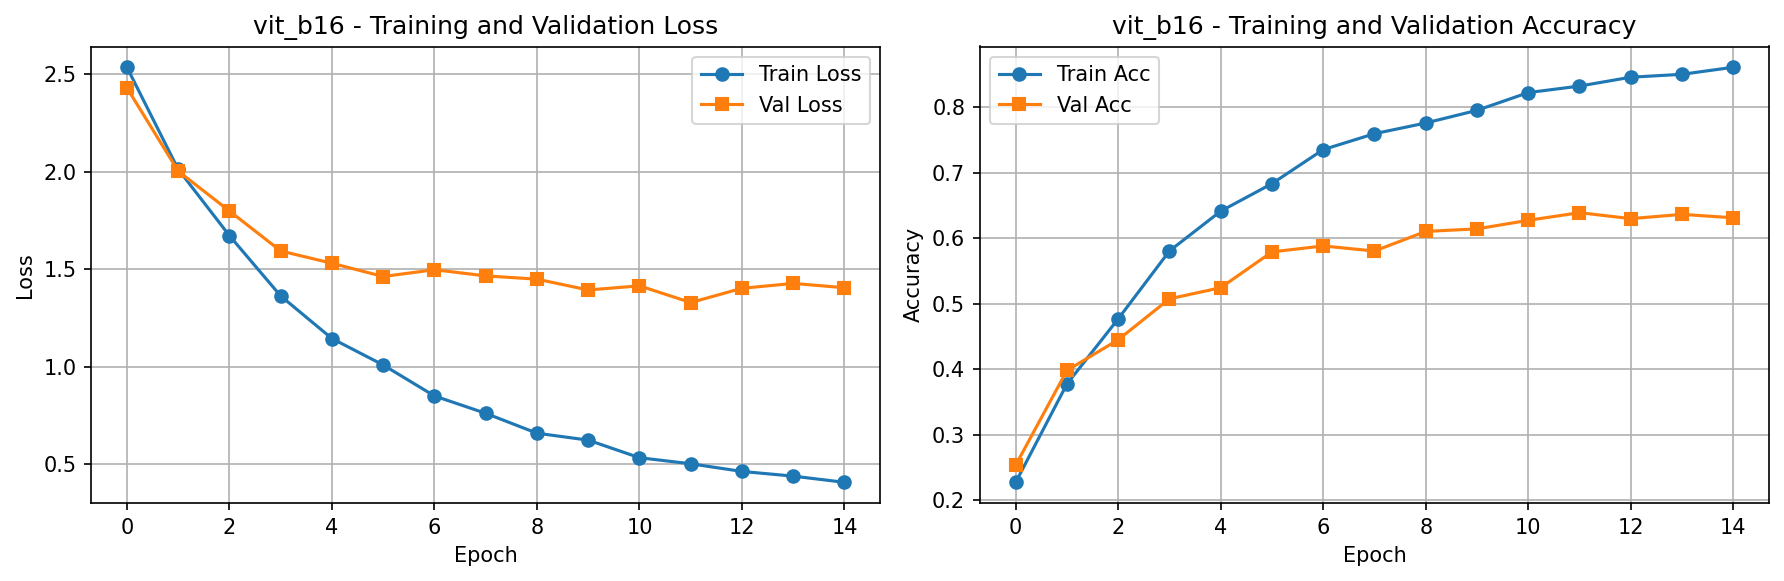



Images for VIT_S16

confusion_matrix.png:


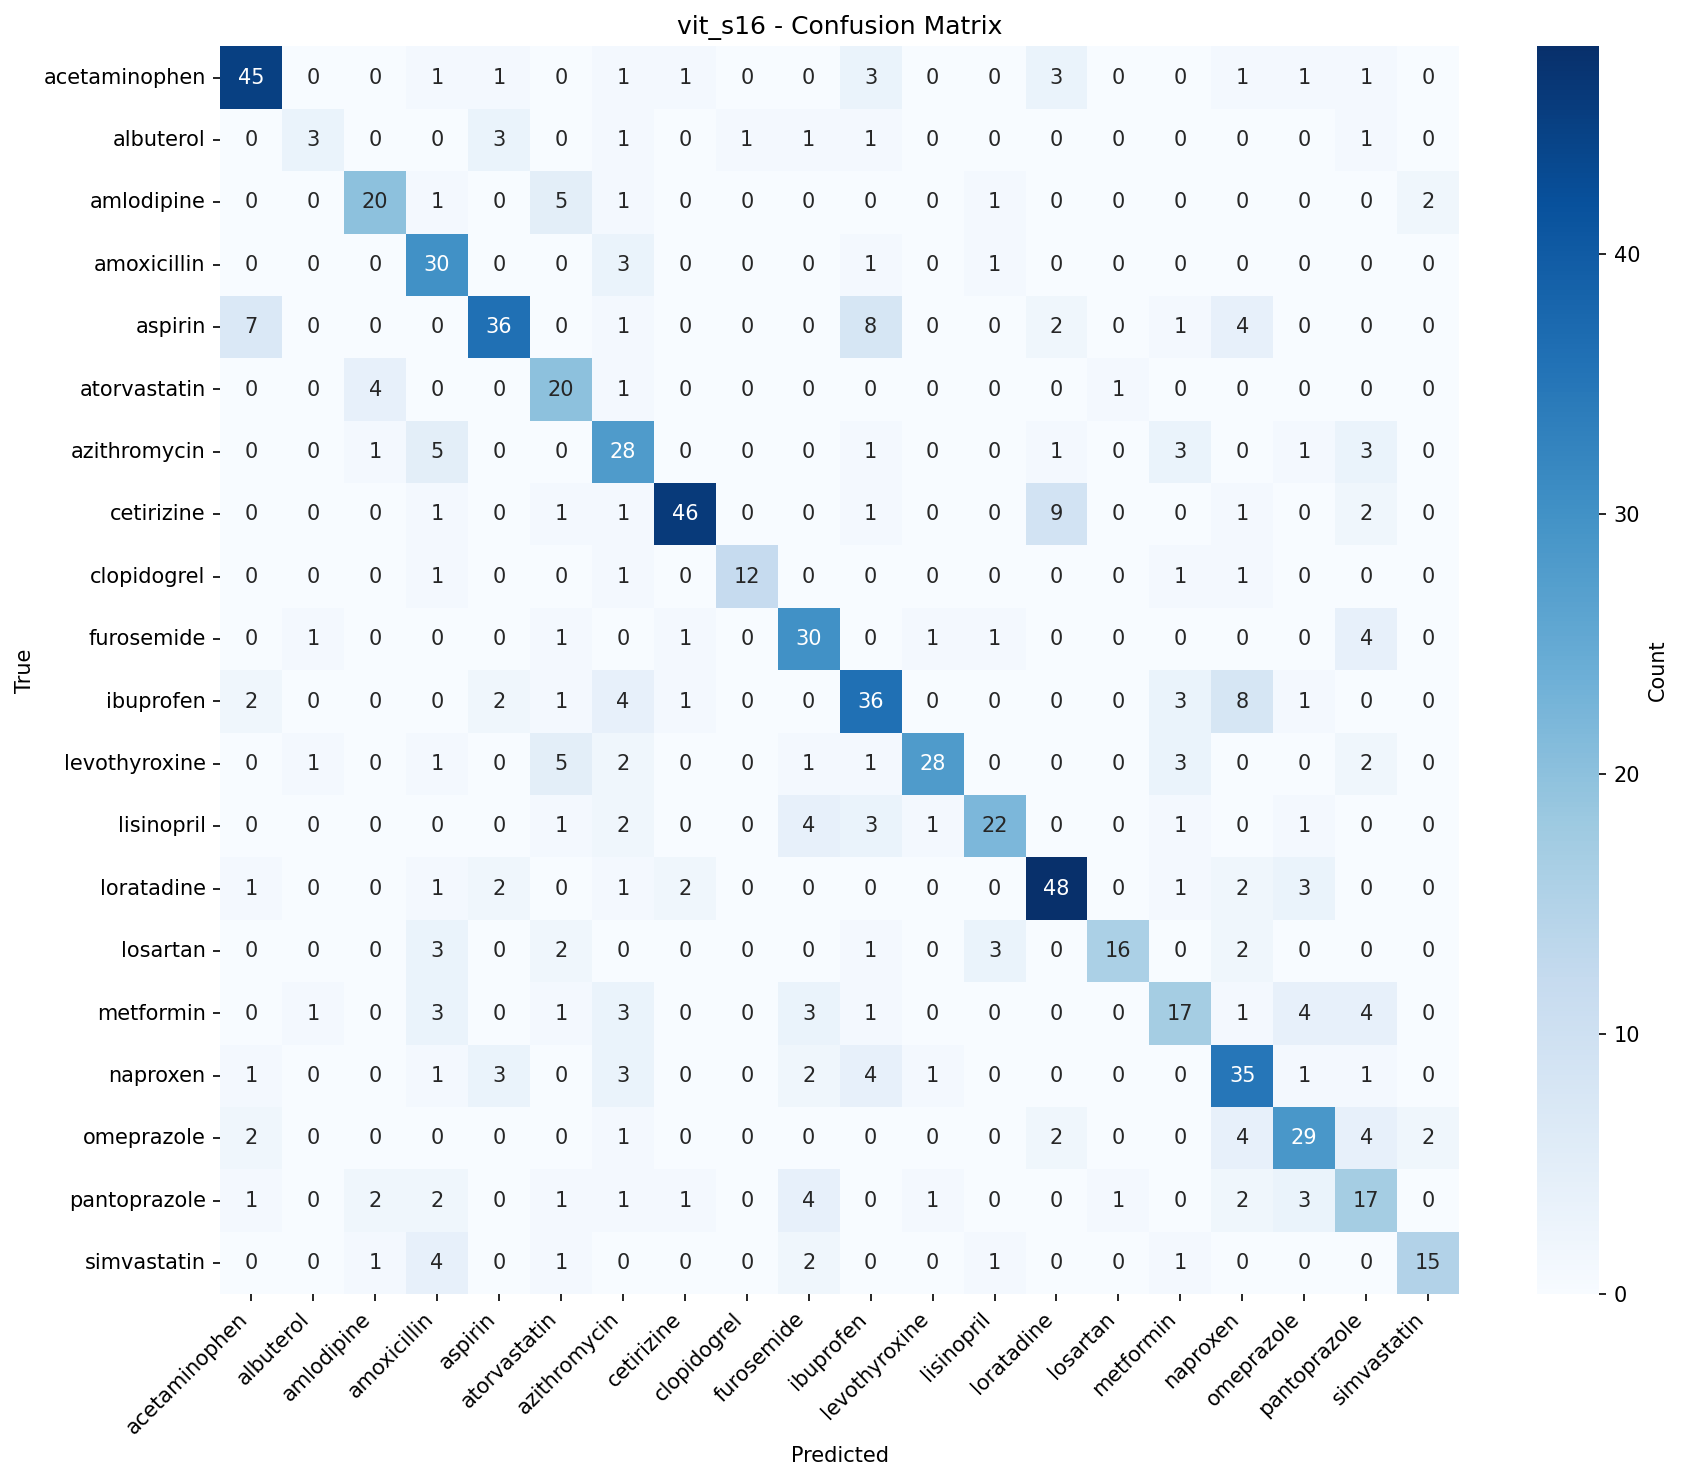


per_class_metrics.png:


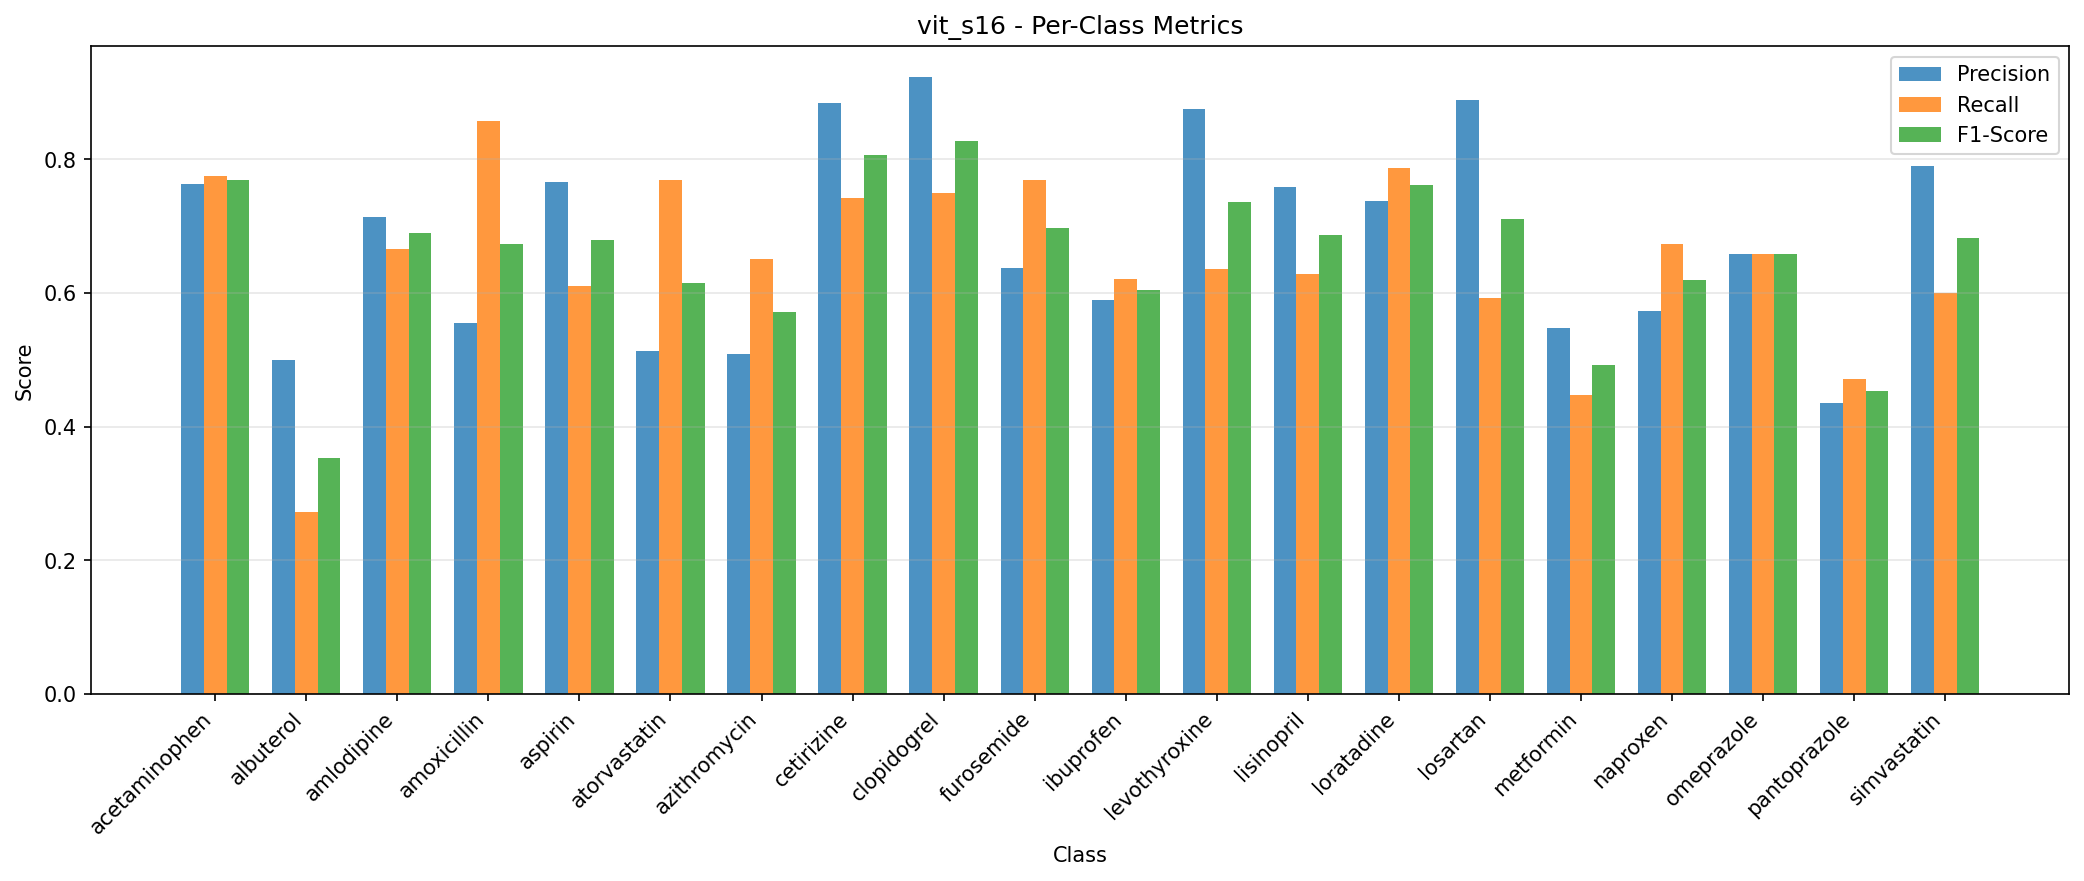


training_history.png:


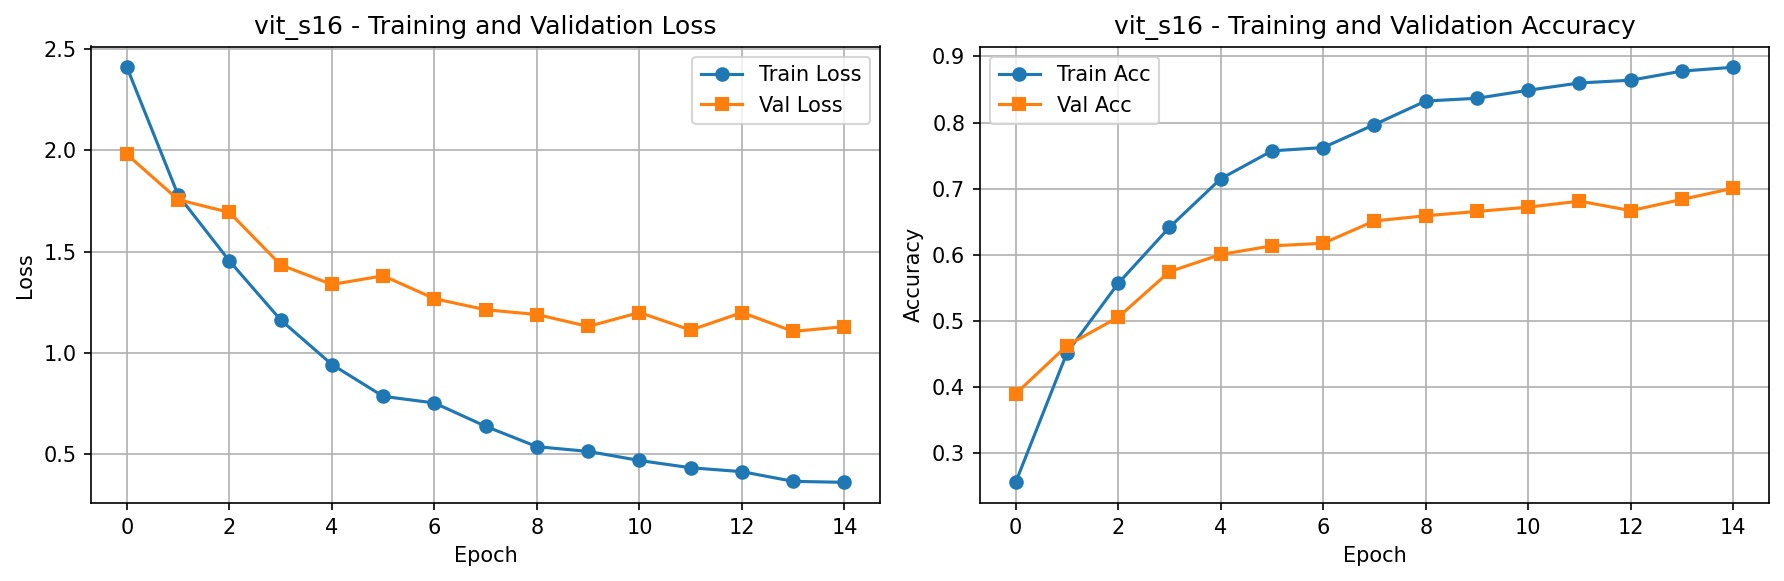



COMPARISON IMAGES

model_comparison.png:


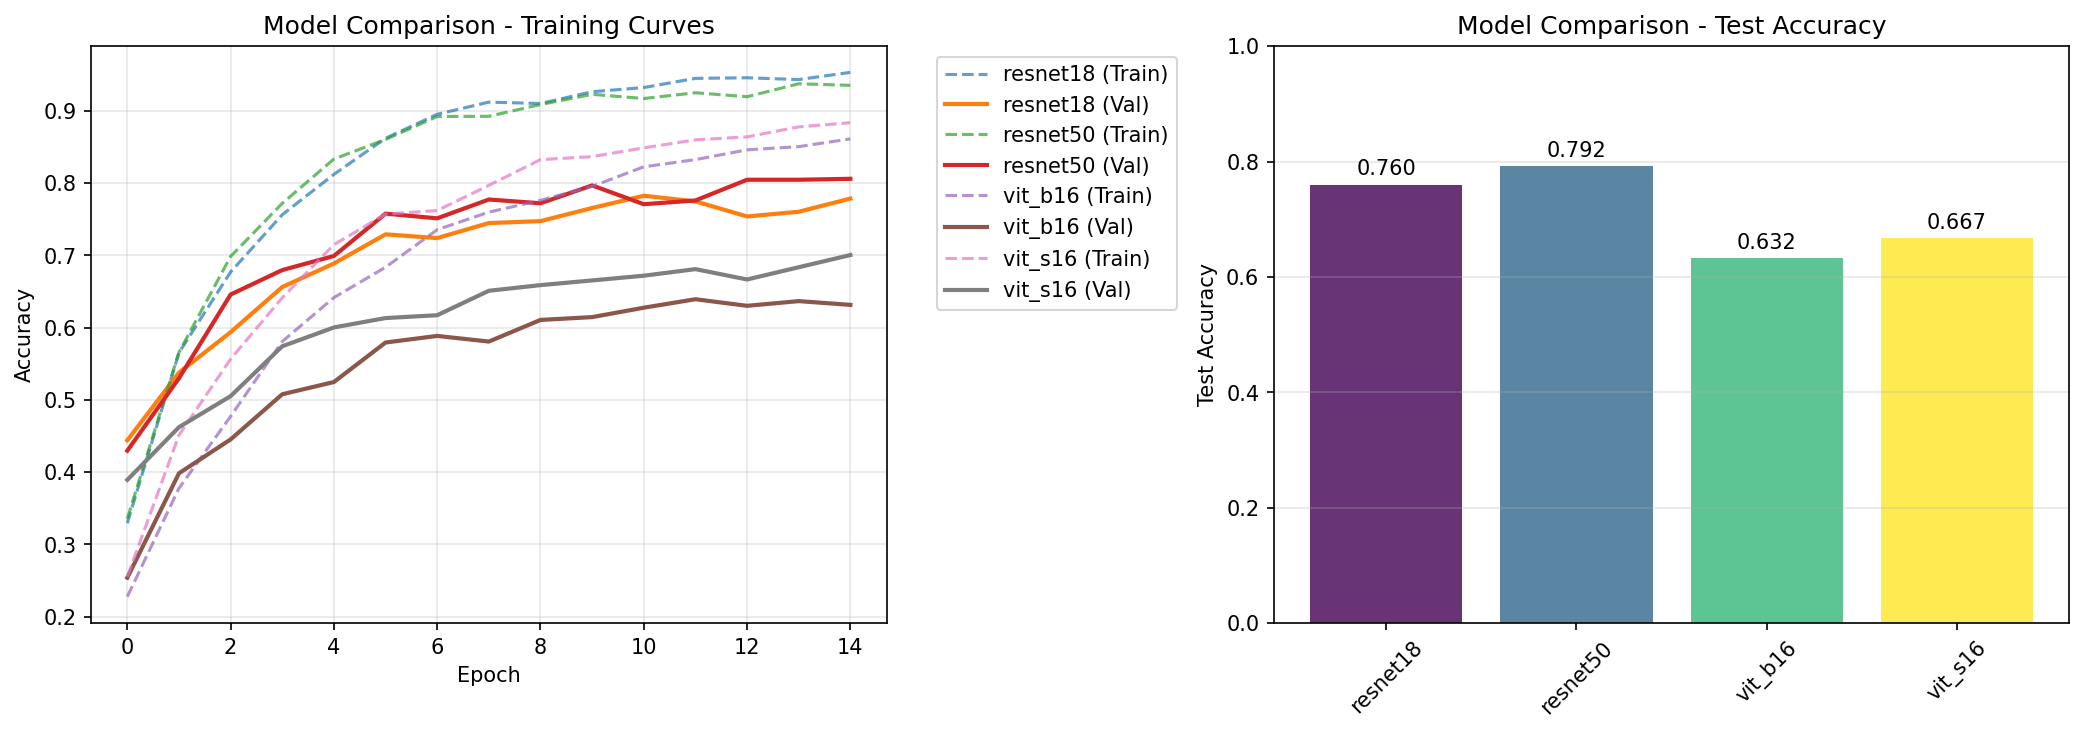

In [23]:
from IPython.display import Image, display
from pathlib import Path

model_dirs = [d for d in os.listdir(results_base)
              if os.path.isdir(os.path.join(results_base, d)) and d not in ['comparison']]

model_dirs = sorted(model_dirs)

for model_dir_name in model_dirs:
    model_dir = os.path.join(results_base, model_dir_name)

    image_files = sorted([f for f in os.listdir(model_dir) if f.endswith('.png')])

    if image_files:
        print(f"\n{'='*80}")
        print(f"Images for {model_dir_name.upper()}")
        print(f"{'='*80}\n")

        for img_file in image_files:
            img_path = os.path.join(model_dir, img_file)
            print(f"{img_file}:")
            display(Image(filename=img_path, width=800))
            print()

comparison_dir = os.path.join(results_base, "comparison")
if os.path.exists(comparison_dir):
    comparison_images = sorted([f for f in os.listdir(comparison_dir) if f.endswith('.png')])

    if comparison_images:
        print(f"\n{'='*80}")
        print("COMPARISON IMAGES")
        print(f"{'='*80}\n")

        for img_file in comparison_images:
            img_path = os.path.join(comparison_dir, img_file)
            print(f"{img_file}:")
            display(Image(filename=img_path, width=800))
            print()


In [27]:
from google.colab import files
files.download("AML_Project.ipynb")

FileNotFoundError: Cannot find file: AML_Project.ipynb